<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/fourier_slice_2D_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* implement Fourier slice theorem in 3D to 2D case


# Set Up

In [ ]:
import numpy as np
import pandas as pd
from scipy import ndimage
import scipy.ndimage.interpolation
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def doplt(arr2d,cmap='gray',**kwargs):
  plt.imshow(arr2d,cmap=cmap,**kwargs)
def logabs(arr):
  return(np.log(1+np.abs(arr)))

In [ ]:
!pip install mrcfile
import mrcfile

In [ ]:
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/fourier.py
!wget https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/twod.py
!wget https://raw.githubusercontent.com/asarnow/pyem/master/pyem/mrc.py
!pip install pyfftw
import fourier, twod

--2020-11-27 22:59:58--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/fourier.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1051 (1.0K) [text/plain]
Saving to: ‘fourier.py.2’

fourier.py.2        100%[===================>]   1.03K  --.-KB/s    in 0s      

2020-11-27 22:59:59 (38.9 MB/s) - ‘fourier.py.2’ saved [1051/1051]

--2020-11-27 22:59:59--  https://raw.githubusercontent.com/geoffwoollard/learn_cryoem_math/8dd2b07fedaafbebe8584e47315d2ffb2c0ff4e5/code/twod.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reques

In [ ]:
%ls

emd_7978.map       fourier.py.1  mrc.py.1      sample_data/  twod.py.2
emd_7978.map.gz.1  fourier.py.2  mrc.py.2      twod.py
fourier.py         mrc.py        __pycache__/  twod.py.1


# Data

In [ ]:
%%bash
#wget ftp://ftp.wwpdb.org/pub/emdb/structures/EMD-7978/map/emd_7978.map.gz
gunzip emd_7978.map.gz

gzip: emd_7978.map.gz: No such file or directory


In [ ]:
f = mrcfile.open('emd_7978.map')
map = f.data
f.close()
N = map.shape[0]

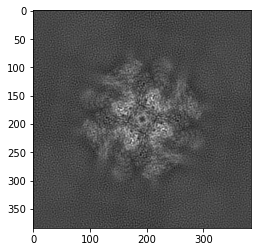

In [ ]:
doplt(map.sum(0))

# Rotation matrix

In [ ]:
def EA_to_R3 (phi, theta, psi=None):
    """
    Makes a rotation matrix from Z-Y-Z Euler angles.
    maps image coordinates (x,y,0) view coordinates
    See Z_1 Y_2 Z_3 entry in the table "Proper Euler angles" at https://en.wikipedia.org/wiki/Euler_angles#Rotation_matrix
    http://www.gregslabaugh.net/publications/euler.pdf
    """
    R_z  = np.array([[ np.cos(phi), -np.sin(phi),  0],
                    [ np.sin(phi),  np.cos(phi),  0],
                    [          0,           0,  1]])
    R_y  = np.array([[ np.cos(theta),  0,  np.sin(theta)],
                    [0,              1,             0],
                    [-np.sin(theta),  0,  np.cos(theta)]])
    R = np.dot(R_z, R_y)
    if psi is not None and psi != 0:
        R_in = np.array([[ np.cos(psi), -np.sin(psi),  0],
                        [ np.sin(psi),  np.cos(psi),  0],
                        [          0,           0,  1]])
    
        R = np.dot(R, R_in);

    return R

def deg_to_rad(deg): return(deg*np.pi/180)

In [ ]:
phi = deg_to_rad(45)
theta = phi
psi = phi
R = EA_to_R3(phi,theta,psi)


In [ ]:
def coords_n_by_d(coords_1d=None,N=None,d=3):
  if N is None: 
    assert coords_1d is not None
  elif coords_1d is None:
    assert N is not None
    coords_1d = np.arange(-N//2,N//2)

  # if d==3:
  #   x,y,z = np.meshgrid(coords_1d,coords_1d,coords_1d)
  #   coords = np.zeros((x.size,3))
  #   coords[:,0] = x.flatten()
  #   coords[:,1] = y.flatten()
  #   coords[:,2] = z.flatten()
  # elif d==2:
  X = np.meshgrid(coords_1d,coords_1d,coords_1d)
  coords = np.zeros((X[0].size,d))
  for di in range(d):
    coords[:,di] = X[di].flatten()

  return(coords)
coords = coords_n_by_d([0,1],d=3)
coords

array([[0., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 1., 0.],
       [1., 1., 1.]])

We apply a rotation matrix to coords and undo it as so:

$$
(\hat r_{nx3} \hat R_{3x3})\hat R_{3x3}^T
$$

In [ ]:
np.allclose(np.dot(np.dot(coords,R), R.T), coords)

True

# Interpolation

So we can calculate a function at points, and then rotate the function by rotating the coordinates by $\hat R$, keeping the values of the mapped coordinates, and interpolating 

In [ ]:
N=10
coords = coords_n_by_d(N=N,d=3)
mu = np.array([0,0,1])
values = np.exp(-.1*np.square(coords-mu).sum(1))

coords_rot = np.dot(coords,R)

In [ ]:
coords_interpolate = coords_n_by_d(N=2*N,d=3)/2
grid = griddata(points=coords_rot,values=values,xi=coords_interpolate)

In [ ]:
grid.shape

(8000,)

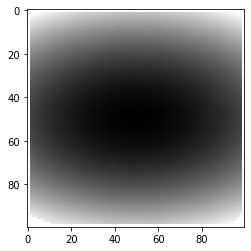

In [ ]:
def func(x, y):
    return x*x+3*y*y
#grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
x = np.linspace(-1,1,100)
grid_x,grid_y = np.meshgrid(x,x)
points = 2*np.random.rand(1000, 2)-1
values = func(points[:,0], points[:,1])
grid = griddata(points, values, (grid_x, grid_y), method='linear')
doplt(grid)

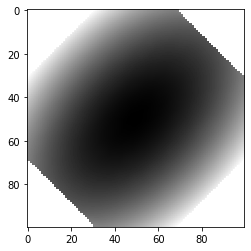

In [ ]:
R_2d = EA_to_R3(np.pi/4,0,0)[:2,:2]
points_rot = np.dot(points,R_2d)
grid_rot = griddata(points_rot, values, (grid_x, grid_y), method='linear')
doplt(grid_rot)

This also works in 3D

In [ ]:
def func(x, y,z):
    return np.exp(-(x*x+3*y*y+10*z*z)/.5)
#grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
x = np.linspace(-1,1,200)
grid_x,grid_y,grid_z = np.meshgrid(x,x,x)
points = 2*np.random.rand(1000, 3)-1
values = func(points[:,0], points[:,1],points[:,2])
interpolated_grid = griddata(points, values, (grid_x, grid_y,grid_z), method='linear')


In [ ]:
points.shape, grid_x.shape, values.shape

((1000, 3), (100, 100, 100), (1000,))

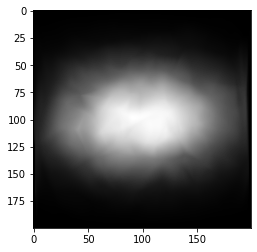

In [ ]:
doplt(np.nansum(interpolated_grid,axis=2))

In [ ]:
R_3d = EA_to_R3(np.pi/4,np.pi/4,np.pi/4)
points_rot = np.dot(points,R_3d)
interpolated_grid_rot = griddata(points_rot, values, (grid_x, grid_y,grid_z), method='linear')


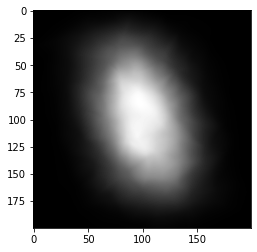

In [ ]:
doplt(np.nansum(interpolated_grid_rot,axis=2))

The 3D interpolation works. There can be some issues wtih edge effects if the volume doesn't go to zero at the edges (not enough padding).

# 2D slice interpolation
Let's do a warm up where we take 2D slices of an object (and know their coordinates), rotate each slice, and then interpolate the whole (rotated) object. The reconstructed object is a bunch of rotated slices, like a egg through an "egg slicer" from the kitchen.

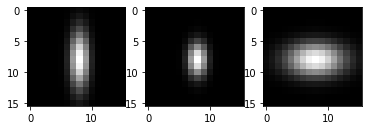

In [ ]:
def gauss(x,y,z,std,cx=1,cy=3,cz=10):
    return np.exp(-(cx*x*x+cy*y*y+cz*z*z)/(2*std))
    
N=16
coords_1d = np.arange(-N//2,N//2)
x,y,z = np.meshgrid(coords_1d,coords_1d,coords_1d)
map = gauss(x,y,z,std=N//1.5,cx=1,cy=3,cz=10)

fig,ax = plt.subplots(nrows=1,ncols=3)
for idx in range(3):
  ax[idx].imshow(map.sum(idx),cmap='gray')
#np.arange(N*N*N).reshape(N,N,N)





In [ ]:
N=32
slices = range(-N//2,N//2)
coords = coords_n_by_d(N=N,d=3)
R_3d = EA_to_R3(np.pi/4,np.pi/4,np.pi/4)
values_i = gauss(coords[:,0], coords[:,1], coords[:,2],std=N//1.5,cx=1,cy=3,cz=10) #np.zeros((len(slices),)+map.shape[:-1])
coords_slice_slice = (N*N,3)
coords_rot = np.zeros((len(slices),)+coords_slice_slice) # dim of slice
values_slice_shape = N*N
values_f = np.zeros((len(slices),)+(values_slice_shape,))
for idx_z,z in enumerate(slices):
  idx_slice = coords[:,-1] == z
  coords_slice = coords[idx_slice]
  values_slice = values_i[idx_slice]
  values_f[idx_z] = values_slice
  #values[idx_z] = func(coords[:,0], coords[:,1], coords[:,2],std=N//1.5)
  coords_rot[idx_z,:,:] = np.dot(coords_slice,R_3d)
  #slice_2d = map[:,:,idx_z]
  #values[idx_z] = slice_2d
  

In [ ]:
coords_rot.shape  , values_f.shape

((8, 64, 3), (8, 64))

In [ ]:
x = np.arange(-N//2,N//2)
grid_x,grid_y,grid_z = np.meshgrid(x,x,x)
%time interpolated_map = griddata(coords_rot.reshape(-1,3), values_f.flatten(), (grid_x, grid_y,grid_z), method='linear')


CPU times: user 2min 56s, sys: 1.26 s, total: 2min 58s
Wall time: 2min 56s


In [ ]:
values_f.flatten().shape, values_i.shape, coords_rot.size/3, coords.size/3

((32768,), (32768,), 32768.0, 32768.0)

## Run time benchmarking

|$N$|$N^3$|`griddata` run time (m:s)|
|-|-|-|
|10|1000|0.2s|
|16|4096|2s|
|32|32768|2m:56s|


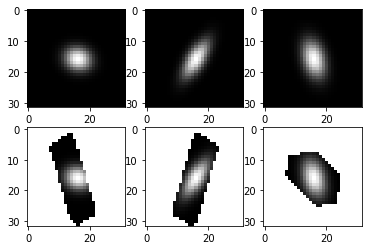

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=3)
for idx in range(3):
  ax[0,idx].imshow(np.nansum(interpolated_map, axis=idx),cmap='gray')
  ax[1,idx].imshow(interpolated_map.sum(idx),cmap='gray')


The interpolation blows up in run time fast with larger box sizes. Also the automatic interpolation leaves some large regions as undefined, so it's important to use `np.nansum` and not `.sum`. `.sum` will bring the whole sum to np.nan if there is a single np.nan in the summed values.

## Rotate 2D slices in real space

When we apply the fourier slice theorem, we are not taking egg slices, but slices through the origin that are rotated differently. This will require differnt book keeping. Let's stick with our same famiiar synthetic example and work out this book keeping before moving onto a cryoEM map.

Pseudo code
```
# for random angels
  # rotate
  # take 2D slice in real space
  # get coords of 2D slice (z value const)
  # unrotate coords (z values varry)
  # keep slice values and new unrot coords
# interpolate
```

In [ ]:
# how does map and coords flatten match

In [ ]:
N=2
map = np.arange(N*N*N).reshape(N,N,N)

In [ ]:
map

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [ ]:
map.flatten()

array([0, 1, 2, 3, 4, 5, 6, 7])

How does `.flatten()` work on an array with shape `(N,N,N)`? 

If 3D value (map) array $m$ is indexed by [x,y,z], with box length N, then it is stored as `m[x0]`=
$$
\begin{bmatrix}
m_{x_0,y_0,z_0} & m_{x_0,y_0,z_1} & ... &  m_{x_0,y_0,z_{N-1}} \\
m_{x_0,y_1,z_0} & m_{x_0,y_1,z_1} & ... &  m_{x_0,y_1,z_{N-1}} \\
... & ... & ... & ... \\
m_{x_0,y_{N-1},z_0} & m_{x_0,y_{N-1},z_1} & ... &  m_{x_0,y_{N-1},z_{N-1}} \\
\end{bmatrix}
$$

This flattens to `m.flatten()= [m[x0].flatten(), ... , m[xN-1].flatten()]`, where `m[xi].flatten()`=$ m_{x_i,y_0,z_0},\  m_{x_i,y_0,z_1},\ ...,\ m_{x_i,y_{N-1},z_{N-1}}$. In other words, `.flatten()` works from the first index, flattens this, then flattens each of these on the next index, etc, until there are just scalars and nothing left to be flattened.




Now, each value element in the flattend map array corresponds to three coordinates (e.g. in cartesian or spherical coordinates). 

The matching coordinates are therefore just the subscript indeces on $m$
$$
...,\ (x_i,y_0,z_0),\  (x_i,y_0,z_1),\ ...,\ (x_i,y_{N-1},z_{N-1}),\ ...
$$

To get the coordinates to match this automatically, we can use `coords_n_by_d` (which doesn't need to be flattened and corresponds to yxz, due to how it does thing internally with `meshgrid`) and then swap the columns to match xyz.

In [ ]:
coords = coords_n_by_d(N=N,d=3) # YXZ to XYZ
coords

array([[-1., -1., -1.],
       [-1., -1.,  0.],
       [ 0., -1., -1.],
       [ 0., -1.,  0.],
       [-1.,  0., -1.],
       [-1.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.]])

In [ ]:
coords[:,[0, 1]] = coords[:,[1, 0]]
coords # no need for more flattening, each row is a coordinate that matches the corresponding element in the flattend value array

array([[-1., -1., -1.],
       [-1., -1.,  0.],
       [-1.,  0., -1.],
       [-1.,  0.,  0.],
       [ 0., -1., -1.],
       [ 0., -1.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.]])

In [ ]:

n_slices=1



In [ ]:
N=16
n_slices = 1000
values_for_interpol = np.zeros((n_slices,N*N))
coords_for_interpol = np.zeros((n_slices,N*N,3))
coords = coords_n_by_d(N=N,d=3)
coords[:,[0, 1]] = coords[:,[1, 0]]
coords_2d_slice_const = coords[coords[:,0] == 0]
np.random.seed(0)

for slice_idx in range(n_slices):
  phi, theta, psi = np.random.uniform(low=-np.pi,high=np.pi,size=3)
  R_3d = EA_to_R3(phi, theta, psi)
  # rotate
  coords_rot = np.dot(coords_2d_slice_const,R_3d)
  slice_2d_values_flat = gauss(coords_rot[:,0],coords_rot[:,1],coords_rot[:,2],std=N//1.5,cx=1,cy=3,cz=10) 
  # slice in real space
  #slice_2d_values = map_rot[N//2,:,:].flatten() # do .sum(0) to project through x-axis
  # keep slice values and new rot coords
  
  values_for_interpol[slice_idx,:] = slice_2d_values_flat
  coords_for_interpol[slice_idx,:,:] = np.dot(coords_2d_slice_const,R_3d)

In [ ]:
slice_2d_values_flat.shape

(256,)

In [ ]:
values_for_interpol.shape, coords_for_interpol.shape

((10000, 64), (10000, 64, 3))

In [ ]:
x = np.arange(-N//2,N//2)
grid_x,grid_y,grid_z = np.meshgrid(x,x,x)
noise = np.random.normal(loc=0,scale=0.01,size=values_for_interpol.size)
%time interpolated_map = griddata(coords_for_interpol.reshape(-1,3), values_for_interpol.flatten() + noise, (grid_x, grid_y,grid_z), method='linear')


CPU times: user 33.1 s, sys: 10.1 s, total: 43.2 s
Wall time: 32.1 s


In [ ]:
coords_1d = np.arange(-N//2,N//2)
x,y,z = np.meshgrid(coords_1d,coords_1d,coords_1d)
map_original = gauss(x,y,z,std=N//1.5,cx=1,cy=3,cz=10)

|N|n_slices|`griddata` runtime|
|-|-|-|
|8|100|0.5s|
|16|100|2.8s|
|16|300|8.1s|
|16|1000|31.4s|


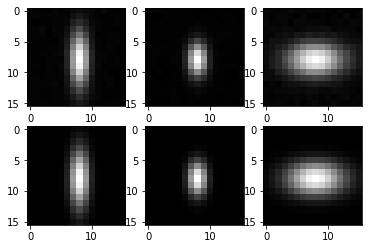

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=3)
for idx in range(3):
  ax[0,idx].imshow(np.nansum(interpolated_map, axis=idx),cmap='gray')
  ax[1,idx].imshow(np.nansum(map_original, axis=idx),cmap='gray')

By changing the noise (`np.random.normal(...,scale=,...)`), we can build some intuition about how many noisy particles it takes to get a good reconstruction, at different noise levels.

# 2D to 3D reconstruction in Fourier space

Pseudo code
```
# for random angels
  # rotate
  # make 3D -> 2D projection in real space
  # make 2D FFT of 2D real space projection
  # get original coords of 2D slice (x value const)
  # rotate coords (x values varry)
  # keep slice values and new rot coords
# interpolate in Fourie space (real and imag separately)
# inverse FFT
```

In [ ]:
%%time
N=32
coords_1d = np.arange(-N//2,N//2)
grid_y, grid_x,grid_z = np.meshgrid(coords_1d,coords_1d,coords_1d) # swap x and y
cx=1;cy=3;cz=10
map_original = gauss(grid_x,grid_y,grid_z,std=N//1.5,cx=cx,cy=cy,cz=cz)
n_slices = 100
values_for_interpol = np.zeros((n_slices,N*N),dtype=np.complex64)
coords_for_interpol = np.zeros((n_slices,N*N,3))
coords = coords_n_by_d(N=N,d=3)
coords[:,[0, 1]] = coords[:,[1, 0]]
coords_2d_slice_const = coords[coords[:,0] == 0]

radially_symetry=False
if radially_symetry:
  proj_2d = np.nansum(map_original,axis=0)
  proj_2d_f = twod.do_fft(proj_2d,only_real=False)

np.random.seed(0)
for slice_idx in range(n_slices):
  if slice_idx%(n_slices/10) == 0:
    print(slice_idx,'%i%% complete'%int(slice_idx/n_slices*100))
  phi, theta, psi = np.random.uniform(low=-np.pi,high=np.pi,size=3)
  R_3d = EA_to_R3(phi, theta, psi)
  # rotate
  coords_rot = np.dot(coords,R_3d)
  if radially_symetry == False:
    values_flat = gauss(coords[:,0],coords[:,1],coords[:,2],std=N//1.5,cx=cx,cy=cy,cz=cz) # use unrot coord
    interpolated_map_rot = griddata(coords_rot, values_flat, (grid_x, grid_y,grid_z), method='linear') # expensive step
    
    # make 3D -> 2D projection in real space
    proj_2d = np.nansum(interpolated_map_rot,axis=0)
    # make 2D FFT of 2D real space projection
    proj_2d_f = twod.do_fft(proj_2d,only_real=False)

  else:
    pass
  
  # get original coords of 2D slice (x value const)
  # coords_2d_slice_const # (precomputed)

  # rotate coords (x values varry)
  coords_2d_slice_rot = np.dot(coords_2d_slice_const,R_3d)

  # keep slice values and new rot coords
  values_for_interpol[slice_idx,:] = proj_2d_f.flatten()
  coords_for_interpol[slice_idx,:,:] = coords_2d_slice_rot

0 0% complete
10 10% complete
20 20% complete
30 30% complete
40 40% complete
50 50% complete
60 60% complete
70 70% complete
80 80% complete
90 90% complete
CPU times: user 4h 44min 59s, sys: 2min 18s, total: 4h 47min 18s
Wall time: 4h 44min 59s


In [ ]:
#noise = np.random.normal(loc=0,scale=0.01,size=values_for_interpol.size)
%time interpolated_map_f_nan = griddata(coords_for_interpol.reshape(-1,3), values_for_interpol.flatten() , (grid_x, grid_y,grid_z), method='linear')
# can do interpolation of real and imag at same time


CPU times: user 27.7 s, sys: 4.27 s, total: 32 s
Wall time: 27.3 s


In [ ]:
interpolated_map_f_filled = np.nan_to_num(interpolated_map_f_nan) # here we just fill the nans to zero. there could be another type of interpolation
map_recon = fourier.do_fft(interpolated_map_f_filled,only_real=False)

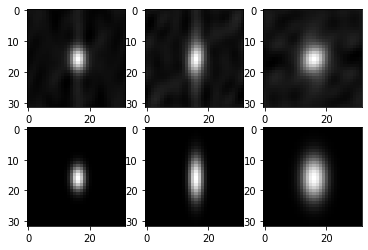

In [ ]:
fig,ax = plt.subplots(nrows=2,ncols=3)
for idx in range(3):
  ax[0,idx].imshow(np.nansum(map_recon.real, axis=idx),cmap='gray')
  ax[1,idx].imshow(np.nansum(map_original, axis=idx),cmap='gray')

In [ ]:
mse = ((map_recon.real/map_recon.real.mean()-map_original/map_original.mean())**2).mean()*100

In [ ]:
'|'.join([str(x) for x in ['',N,n_slices,'%1.2f'%mse,'','','']])

'|32|100|609.78|||'

|N|n_slices|mse[r/r.mean,o/o.mean] (%)|map|runtime|
|-|-|-|-|-|
|16|3|15|symmetric sphere||
|16|10|1.6|||
|16|30|0.79|||
|16|100| 0.23||seconds (because 2D projections all same and precomputed)|
|16|10|143.35|gaussian streached differently in xyz|~1min|
|16|100|217.90||~3.5min|
|32|100|609.78||4.75hrs|

Simulating the images is the bottle neck. With a radially symetric object they are always be the same and can be precomputed. Perhaps there is a way to work out the line integrals purely analytically.